
# Bank Statement Analysis

### The purpose of this program is to compare incoming/outgoing Transactions from a Wells Fargo's Checking Account

#### Import appriopiate libraries

In [1]:
import numpy as np
import pandas as pd
import csv
import re
import datetime as dt

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

#### Read and clean data to create a Dataframe

In [2]:
d = pd.read_csv('checking_21-22.csv')
df = pd.DataFrame(data=d)
# print(df.columns)
df.columns= ['A','B','C','D','E'] #Default column names

df = df.drop(columns=['C','D']) # Remove useless columns
df = df.rename(columns = {'A':'Dates',  'B':'Transactions', 'E':'Informations'}) # Coordinate actual column name


# Begin at an inital point
# df.loc[len(df)] = [df['Dates'][len(df) - 1], 0, '***** INTIAL TRANSACTION *****']


# with pd.option_context('display.max_rows', None,'display.max_columns', None, 'display.precision', 2):
#     print(df)

pd.set_option('display.max_colwidth', None) # Shows ALL text within the Series

df = df.iloc[::-1] #reverse dataframe
df.reset_index(drop=True, inplace=True) # resets the first element in dataframe back to 0

# display(df)

# Series: By convention, Series variables are capitalized 
Dates = df['Dates']
Transactions = df['Transactions']
Informations = df['Informations']

## Pie Chart  (Profit vs. Loss)

We will extract Informationsrmation from the 'Transactions' column and categorized them based on representation

In [7]:
withdrawls = df[Transactions < 0] #give the dataframe where the value of this.column is less than 0
deposits = df[Transactions >= 0]

loss = profit = 0.0

for ele in Transactions:

    if ele < 0:
        loss += float(ele)
    else:
        profit += float(ele)


print('Profit: ', profit, 'Loss: ', loss)
print("Total Difference = ", profit + loss)


# print(deposits.head)

Profit:  58423.60999999999 Loss:  -59671.56999999998
Total Difference =  -1247.9599999999846


(-1.1040468369809409,
 1.100192706522902,
 -1.1023791261155422,
 1.1045291287373473)

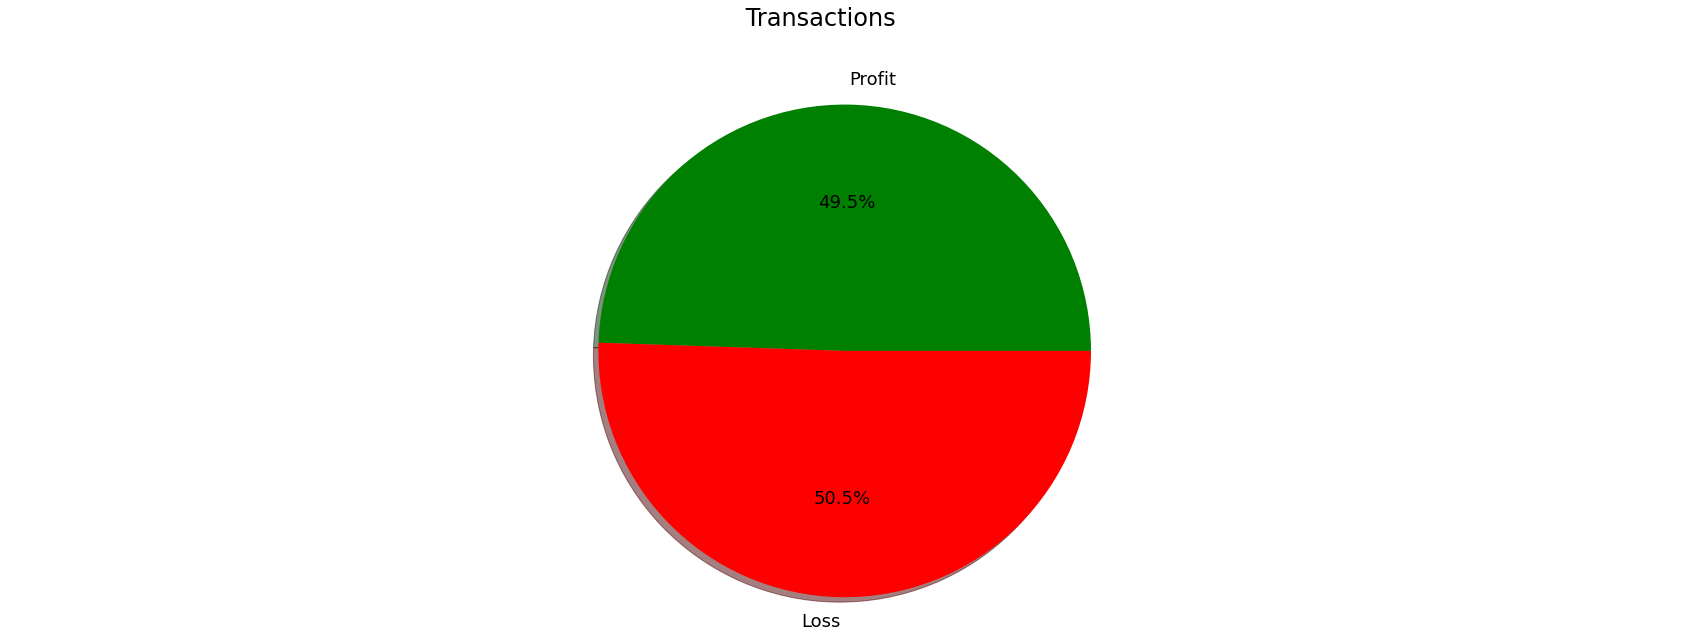

In [4]:
labels = 'Profit' , 'Loss'
gains = [profit, abs(loss)]
colors = 'green', 'red'

size = (30,10) 

pie_fig, ax = plt.subplots(figsize = size) # whole figure is 10x10
pie_fig.set_facecolor('white')
pie_fig.suptitle(' Transactions', fontsize=24)

ax.pie(gains, labels=labels, shadow=True, autopct='%1.1f%%', textprops={'fontsize': 18}, colors=colors)
ax.axis('equal')

## Line Graph (Transaction Flow)

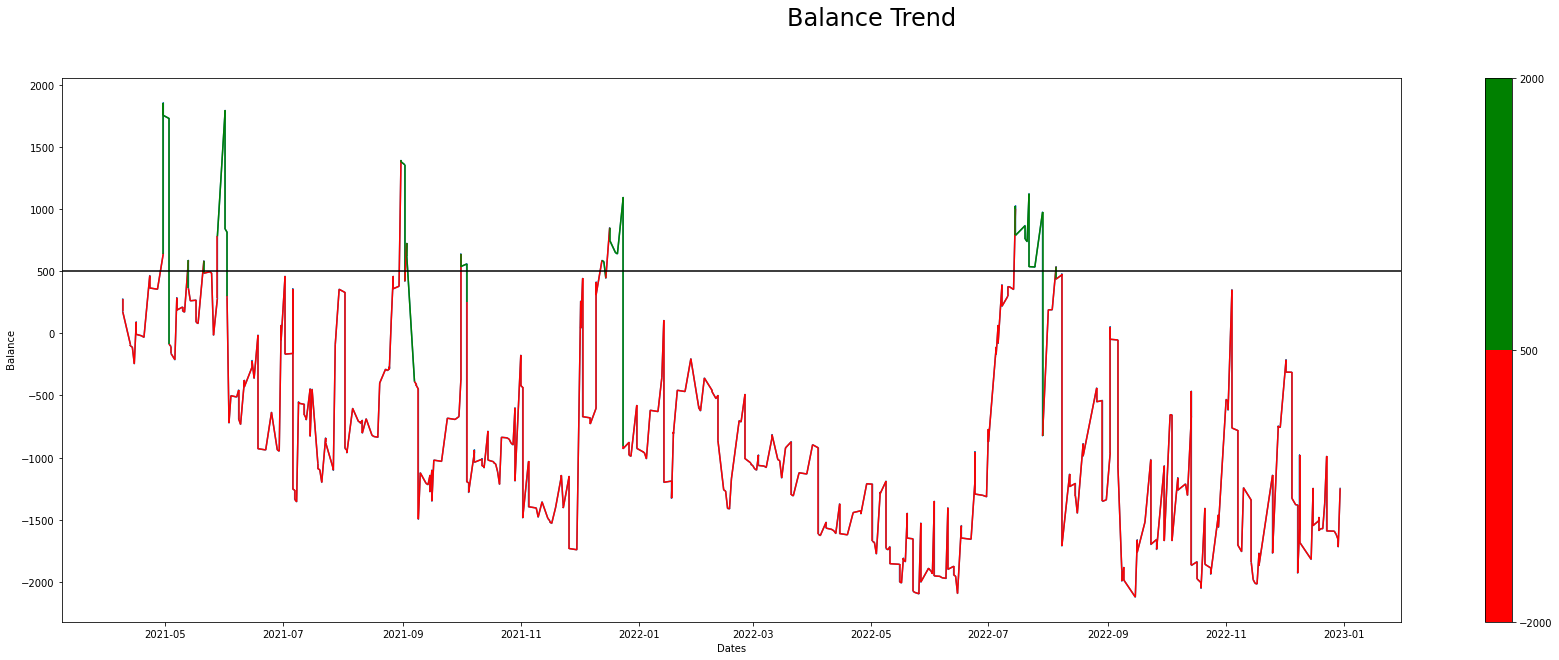

In [5]:
#Note: Below will express the date format in %m : months | %d : day | %y : year
# %Y signifies 4 digits (ex. 2022) as %y signifcies 2 digits (ex:22)

def transformer(date):
    parsed = date.split('/')
    parsed[1] = '0' + parsed[1] # adjust day
    if parsed[2] == re.compile('\d{2}'):
        parsed[2] = '20' + parsed[2] # adjust year
    date = ('/').join(parsed) 
    # print(Dates, "changed at", count)
    return date

line_fig, ax1 = plt.subplots(figsize=size)
line_fig.suptitle('Balance Trend', fontsize = 24)

labels = ['Dates', ' Balance']
colors = ['red', 'green']
gained = 0
balance = pd.Series([], dtype='float64')
maxbal = max(Transactions)
minbal = -maxbal
threshold = 500


# print(max(Transactions))

ax1.set_ylim(auto=True)

plt.xlabel(labels[0])
plt.ylabel(labels[1])

# Adjust the Dates
pattern = re.compile('\d+/\d{1}/\d{2}')

for count,date in (enumerate(Dates)): 
    if pattern.match(date):
        Dates[count] = transformer(date)
        # print(Dates[count])
    break

x = [dt.datetime.strptime(d,'%m/%d/%y').date() for d in Dates]

# Get updated balance after each transaction
for count,each in enumerate(Transactions):
    gained += each
    balance[count] = gained #append into Series df['Balance']
   

plt.plot(x, balance)

if'Balance' not in df.columns:
    df.insert(3,'Balance', balance)

# y = df['Balance']

cmap = ListedColormap([colors[0], colors[1]])
norm = BoundaryNorm([minbal, threshold, maxbal], cmap.N)

inxval = mdates.date2num(x) # converts Dates within x list to numbers

# print(df.head())


points = np.array([inxval, balance.values]).T.reshape(-1,1,2)

# print(points)

segments = np.concatenate([points[:-1], points[1:]], axis=1)

line_collection = LineCollection(segments, cmap=cmap, norm=norm)
line_fig.colorbar(ax1.add_collection(line_collection), ax=ax1)
line_collection.set_array(balance.values)

ax1.axhline(y=threshold, color='black', linestyle='-')


As displayed in the graph above, the respresentation of each Transactions is expressed after its mark; line becomes red after hitting the 'Below Threshold' mark.<br/>
Attempted to express 'Below Threshold' before hitting the point, but was unsuccessful.

## Bar Graph Comparision

This graph simply compares the balance of the month from current and last year.

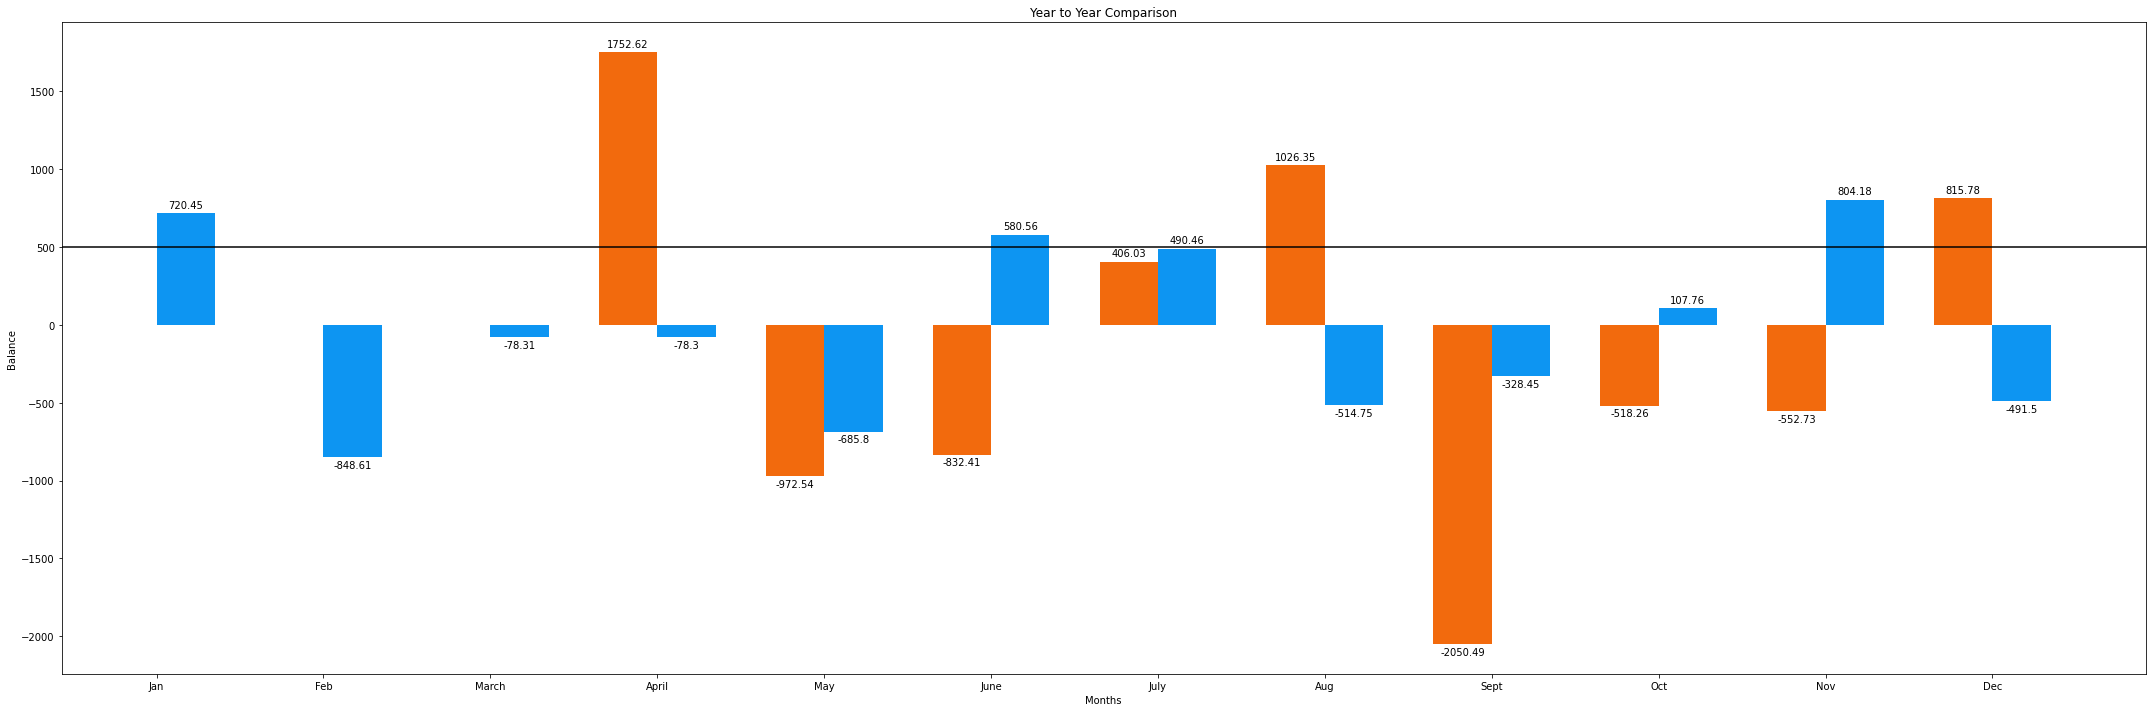

In [8]:

def merge(x):

    months = []
    total = 0

    for count, ele in enumerate(x):

        # print(count, ele, x[count], Transactions[count])

        # print(ele.month,  ele.year, ele.day)
        # print('in bal: ', Transactions[count])

        if count < len(x) - 1 and ele.month == x[count + 1].month: # Next month matches current month
            total += Transactions[count]
        else:
            total += Transactions[count]
            months.append(('-'.join((str(ele.year), str(ele.month))), round(total,2)))
            total = 0

    return months

# Fill in NaN for empty data in months
def fillMonths(year):
    global monthsofYear
    # monthsofYear = ['Jan', 'Feb','March','April','May','June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    m = [months[0].split('-')[1] for months in year]
    currYear = year[0][0].split('-')[0]

    for i in range(len(monthsofYear)):

        if str(i+1) not in m:
            year.insert(i,('-'.join((currYear, str(i+1))),np.nan))
                            
    return year

results = merge(x)

# print('Month Gaps: ', results)

#Below is the list comprehension for quick assignment
twentyOne = [day for day in results  if '2021' in day[0]]
twentyTwo = [day for day in results  if '2022' in day[0]]

bar_fig, ax2 = plt.subplots(figsize=size)
labels2 = ['orange', 'green']
years = [year for year in results ]
monthsofYear = ['Jan', 'Feb','March','April','May','June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


x1 = np.arange(len(monthsofYear))
width = 0.35

fillMonths(twentyOne)
fillMonths(twentyTwo)

# print(results)
twentyOne_list = [list(each) for each in twentyOne]
twentyTwo_list = [list(each) for each in twentyTwo]

results_list = twentyOne_list + twentyTwo_list
# print('Months without Gaps: ',results) 

ax2.set_title('Year to Year Comparison')
ax2.set_ylabel('Balance')
ax2.set_xlabel('Months')
# ax2.bar_label()
ax2.set_xticks(x1, monthsofYear)

# ax2.legend() # if we can manage 2 instance of legend with not literateral iteration


for i in range(len(results_list)):
    if i < len(monthsofYear) and i+1 == int(results_list[i][0].split('-')[1]): #Handles all 2021 bars
        rect1 = ax2.bar(x1[i] - width/2, results_list[i][1], width, color= '#f26a0d', label='2021')
        ax2.bar_label(rect1, padding=3) # Showing value of the bar above

    elif i >= len(monthsofYear) and i % len(monthsofYear) + 1 == int(results_list[i][0].split('-')[1]): #Handles all 2022 bars
        rect2 = ax2.bar(x1[i % len(monthsofYear)] + width/2, results_list[i][1], width, color= '#0d95f2', label='2022')
        ax2.bar_label(rect2, padding=3)

ax2.axhline(y=threshold, color='black', linestyle='-')


bar_fig.tight_layout()



Okay? We see a bunch of bars on the graph, but how can we understand them better?
We will turn this into a new set of dataframe, comparing the balances in terms of differences (percentage and decimal)

No matter how we display our data, my pockets doesn't appear happy with me. So, let's find out where all these miscellaneous spending are coming from!

## Categorical View

All card transactions are categorized by merchant category codes (mcc). This is how we are going to distinguish spending and find the culprit that drains my account!<br/>
... After recent research, I came to realization that we cannot derive mcc from a printed document 😒.



## Machine Learning (Making Predictions)

Let's stop here. <br/>
I've discorvered I did not have an appropiate dataset to continue this experiment,<br/> and conclude this to be the basic version<br/>